In [2]:
using LinearAlgebra
using SwitchOnSafety
using ControlSystems
using StaticArrays
using HybridSystems
using JuMP
using MosekTools
using Random
using LightGraphs
using SpecialFunctions
using Arpack

In [3]:
CJSR = .95
G = LightAutomaton(2)
add_transition!(G, 1, 1, 1)
add_transition!(G, 1, 2, 2)
add_transition!(G, 2, 1, 2)

HybridSystems.LightTransition{LightGraphs.SimpleGraphs.SimpleEdge{Int64}}(Edge 2 => 1, 3)

In [16]:
A1_2 = [-0.12264385232852724 -0.5132986766380205; -0.512239944583497 0.7657920763290312] 
A2_2 = [-1.0025775249390196 0.35564172966144936; -0.01094819510863365 0.5106100376225976] 
Σ_2 = [A1_2, A2_2]

A1_3 = [0.09052970480096943 -0.48983627637678495 0.35393631188643254; -1.4102510663571808 -0.29603879196786076 -0.07234411571531388; -0.14141377348869863 -0.7488699937150097 0.27614247133103026]
A2_3 = [-0.5939286228663733 0.5535426721612529 1.2248015944818176; 0.408167813638229 0.8763244470981735 0.34020098544574057; -0.6060865277042067 -0.05753029855797154 -0.5839547395592828]
Σ_3 = [A1_3, A2_3]

A1_4 = [0.4375384908998181 0.7795355770667252 -0.040099732530774146 -0.9564589786862254; -0.3584137805621985 0.5029762608178756 0.8425925749366162 0.047141361920994176; -0.2122617369439823 0.3400430543990932 -0.6193243388767498 -0.2548568896262528; -0.5348879889590828 -0.4480647159808548 0.22667437197876164 0.47926967971510176]
A2_4 = [0.40585387400758044 -0.20768007117355278 -0.40531844944814416 0.7693763101060594; 0.3904731792448494 0.019051310534303843 -0.018487375220524044 0.8895232021535535; 1.0853492832256844 -0.5035357436868629 0.36150631725258847 -0.18468125200170102; -0.5794584798986746 -0.32184050196635594 0.3553477751497201 0.9469177219636563]
Σ_4 = [A1_4, A2_4]

A1_5 = [-0.06307480402303137 0.5280995363461506 -0.004101271836206635 -0.37531257407235774 -0.5329050052128116; -0.3465538216826522 0.16895463652750348 0.27757855949094407 -0.35499324559732354 0.9662239420459873; -0.5456706356225736 -0.20081555629274084 -0.06090206291960528 0.17685768398708618 0.4732237247613474; -0.32281209656223225 -0.029600337572470315 -0.5067884085242049 -0.7324477402283953 -0.14831802744209363; -0.1156836687582911 -0.2884286190877954 0.3393287621745705 -0.19226110081584863 -0.4235914578487072]
A2_5 = [0.19995160026320255 0.11420853472585275 0.11894645812625691 -0.0321565153396973 -0.33414740360705303; -0.19120437801981657 0.1580328710636839 -0.024895108741009128 0.20169822805023205 0.18151280482185522; 0.19700752206599945 0.6967664962237133 0.16301825640202722 0.020859211026323963 0.5003448906619238; -0.20387169402381075 0.10646644945126305 0.5308799607574144 -0.2724196354999126 0.048406470573328295; 0.09298522902986386 -0.3208636298456948 0.6003699388837593 0.19617952171942324 0.5393599948716818]
Σ_5 = [A1_5, A2_5]

m = 2
for Σ in [Σ_2, Σ_3, Σ_4, Σ_5]
    for i in 1:size(Σ)[1]
        Σ[i] *= CJSR
    end
end

nothing

In [21]:
hs = discreteswitchedsystem(Σ_5, G)
include("../../../src/WhiteBox.jl")
@show white_box_CJSR_upper_bound(hs, 2)

white_box_CJSR_upper_bound(hs, 2) = 0.9500062759955281


0.9500062759955281

In [64]:
VERBOSE = true

include("../../../src/Trajectories.jl")
include("../../../src/Bounds.jl")

N = 6000
N_step = 1000
N_begin = 1000
N_range = N_begin:N_step:N

# Known information
V = nstates(G)
m = 2

# Parameters
β = .99
β1 = (β + 1.) / 2.
β2 = β1

for Σ in [Σ_2, Σ_3, Σ_4, Σ_5]
    dim = size(Σ[1])[1]
    if VERBOSE @show dim end
    total_time = 0

    f = open("res_MQLF_$dim.txt", "w")
    println("Simulations start for dim = $dim")
    for n = N_range
        u, v, x, y = generate_trajectories(Σ, G, n, 1)
        y = reshape(y, size(x))
        total_time += @elapsed lower_bound, upper_bound = bounds_MQLF(x[:, 1:n], u[1:n], y[:, 1:n], v[1:n], V, β1, β2, m)
        println(f, "$lower_bound $upper_bound")
    end
    close(f)

    if VERBOSE @show total_time end
end

dim = 2
Simulations start for dim = 2
total_time = 9.460152709
dim = 3
Simulations start for dim = 3
total_time = 10.967940561
dim = 4
Simulations start for dim = 4
total_time = 17.272797989
dim = 5
Simulations start for dim = 5
total_time = 27.650483924999996


sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


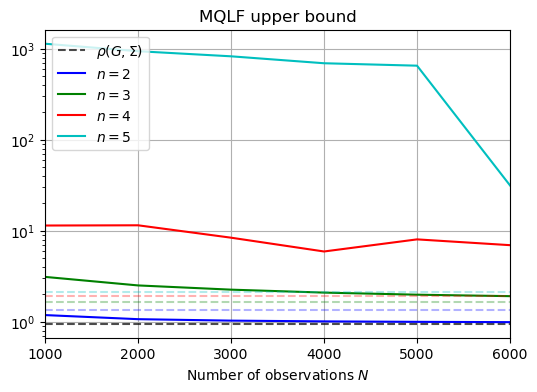

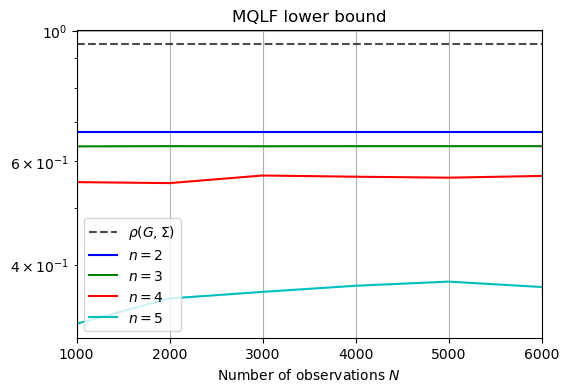

In [10]:
using DelimitedFiles
using PyPlot

N = 6000
N_step = 1000
N_begin = 1000
N_range = N_begin:N_step:N

colors = ["b", "g", "r", "c", "m", "y", "orange"]

figure(figsize=(6, 4))
axhline(CJSR, linestyle="--", color="k", alpha=.7, label="\$\\rho(G, \\Sigma)\$")
for dim in 2:5
    data_MQLF = readdlm("res_MQLF_$dim.txt")
    keep_MQLF = map(x -> x != -1, data_MQLF[:, 2])
    keep_MQLF = reshape(keep_MQLF, size(N_range))
    plot(N_range[keep_MQLF], (data_MQLF[:, 2])[keep_MQLF], "-", color=colors[dim - 1], label="\$n = $dim\$")
    axhline(dim^(1/2) * CJSR, alpha=0.3, color=colors[dim - 1], linestyle="--")
end
title("MQLF upper bound")
legend(loc="upper left")
yscale("log")
xlabel("Number of observations \$N\$")
margins(x=0)
PyPlot.grid()
show()
savefig("dimension_MQLF_ub.pdf")

figure(figsize=(6, 4))
axhline(CJSR, linestyle="--", color="k", alpha=.7, label="\$\\rho(G, \\Sigma)\$")
for dim in 2:5
    data_MQLF = readdlm("res_MQLF_$dim.txt")
    plot(N_range, data_MQLF[:, 1], "-", color=colors[dim - 1], label="\$n = $dim\$")
end
title("MQLF lower bound")
legend()
yscale("log")
xlabel("Number of observations \$N\$")
margins(x=0)
PyPlot.grid()
show()
savefig("dimension_MQLF_lb.pdf")

In [20]:
include("../../../src/Trajectories.jl")
include("../../../src/Bounds.jl")

N = 6000
N_step = 1000
N_begin = 1000
N_range = N_begin:N_step:N

# Known information
V = nstates(G)
m = 2

# Parameters
β = .99
β1 = (β + 1.) / 2.
β2 = β1

l = 1
pl_min = .25
pl_max = .75
quantity = 1 / pl_min
quantity_max = 1 / pl_max

for Σ in [Σ_2, Σ_3, Σ_4, Σ_5]
    dim = size(Σ[1])[1]
    if VERBOSE @show dim end
    total_time = 0

    f = open("res_CQLF_$dim.txt", "w")
    println("Simulations start for dim = $dim")
    for n = N_range
        u, v, x, y = generate_trajectories(Σ, G, n, 1)
        y = reshape(y, size(x))

        total_time += @elapsed upper_bound = upper_bound_CQLF(x, y, β, l, quantity, quantity_max = quantity_max)     
        println(f, "$upper_bound")
    end
    close(f)

    if VERBOSE @show total_time end
end

dim = 2
Simulations start for dim = 2
bound1 = 0.9522797132497521
bound2 = 1.0222054794777726
bound1 = 0.9506040669339525
bound2 = 1.0199829772662017
bound1 = 0.9502924048056457
bound2 = 1.0190882791014495
bound1 = 0.9501832445492001
bound2 = 1.0186671674381609
bound1 = 0.9501326586503609
bound2 = 1.0183398649108766
bound1 = 0.9501052055379414
bound2 = 1.0182195572605386
total_time = 31.900236649999997
dim = 3
Simulations start for dim = 3
bound1 = 1.5152635261776004
bound2 = 2.6275092355248626
bound1 = 1.4572663719293992
bound2 = 2.9585572133595415
bound1 = 1.426077390731807
bound2 = 2.617910592351089
bound1 = 1.413657084732353
bound2 = 2.745361191518871
bound1 = 1.4096878403752113
bound2 = 3.234320796417484
bound1 = 1.4050978592195313
bound2 = 2.99861912961611
total_time = 89.259140959
dim = 4
Simulations start for dim = 4
bound1 = 4.503355606270039
bound2 = 29.01507044566635
bound1 = 1.7662696334273735
bound2 = 15.095455353421473
bound1 = 1.6191683924390716
bound2 = 18.8792156223273

sys:1: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.


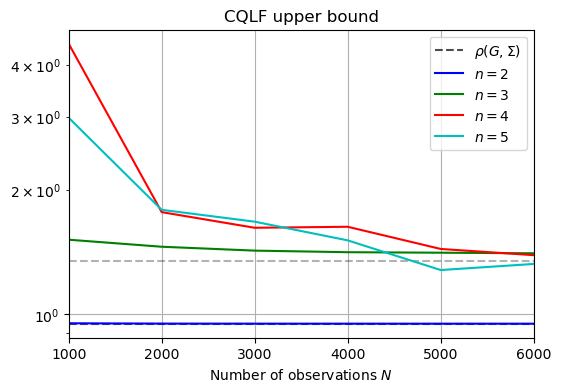

In [22]:
m = 2
N = 6000
N_step = 1000
N_begin = 1000
N_range = N_begin:N_step:N
figure(figsize=(6, 4))
axhline(CJSR, linestyle="--", color="k", alpha=.7, label="\$\\rho(G, \\Sigma)\$")
axhline(m^(1/2)*CJSR, linestyle="--", color="k", alpha=0.3)
for dim in 2:5
    data_CQLF = readdlm("res_CQLF_$dim.txt")
    keep_CQLF = map(x -> x != -1, data_CQLF)
    keep_CQLF = reshape(keep_CQLF, size(N_range))
    plot(N_range[keep_CQLF], (data_CQLF)[keep_CQLF], "-", color=colors[dim - 1], label="\$n = $dim\$")
end
title("CQLF upper bound")
legend()
yscale("log")
xlabel("Number of observations \$N\$")
margins(x=0)
PyPlot.grid()
show()
savefig("dimension_CQLF_ub.pdf")